In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd 
import seaborn as sns
import umap
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

/Users/charlottecheung/miniforge3/envs/asn4/lib/python3.11/site-packages/umap/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [59]:
X_train_initial = np.load('X.npy') # rows = genes, columns = samples
# Read gene names (one-per-line). Take the first entry before '///' if present.
df = pd.read_csv('gene_names.txt', header=None, names=['gene'])
df_chars = pd.read_csv('metadata_types.txt', header=None, names=['type'])
# Normalize empty/nan and keep the first gene if multiple like 'A /// B'
df['gene'] = df['gene'].fillna('').astype(str)
df['gene'] = df['gene'].apply(lambda s: s.split('///')[0].strip() if s else '')
y_train = df['gene'].values

scaler = StandardScaler()

X_train = X_train_initial #rows = samples, columns = genes
X_train_scaled = scaler.fit_transform(X_train)

#print(df_chars[:10])
df_chars_train = df_chars['type'].values
print(df_chars_train[:10])



['leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)'
 'leukemia class: mature B-ALL with t(8;14)']


In [60]:
print(y_train.shape)
print(X_train_scaled.shape)

X_train_df = pd.DataFrame(X_train_scaled)
X_train_df['gene'] = y_train
X_train_df_cleaned = X_train_df.dropna(axis=0, how='any')

y_train = X_train_df_cleaned['gene']
X_train_scaled = X_train_df_cleaned.drop(columns=['gene']).values
print("cleaned")
#print(y_train.shape)
#print(X_train_scaled.shape)
print(df_chars.shape)
print(df_chars[:10])

(54675,)
(54675, 2096)
cleaned
(2096, 1)
                                        type
0  leukemia class: mature B-ALL with t(8;14)
1  leukemia class: mature B-ALL with t(8;14)
2  leukemia class: mature B-ALL with t(8;14)
3  leukemia class: mature B-ALL with t(8;14)
4  leukemia class: mature B-ALL with t(8;14)
5  leukemia class: mature B-ALL with t(8;14)
6  leukemia class: mature B-ALL with t(8;14)
7  leukemia class: mature B-ALL with t(8;14)
8  leukemia class: mature B-ALL with t(8;14)
9  leukemia class: mature B-ALL with t(8;14)
cleaned
(2096, 1)
                                        type
0  leukemia class: mature B-ALL with t(8;14)
1  leukemia class: mature B-ALL with t(8;14)
2  leukemia class: mature B-ALL with t(8;14)
3  leukemia class: mature B-ALL with t(8;14)
4  leukemia class: mature B-ALL with t(8;14)
5  leukemia class: mature B-ALL with t(8;14)
6  leukemia class: mature B-ALL with t(8;14)
7  leukemia class: mature B-ALL with t(8;14)
8  leukemia class: mature B-ALL with t(8;

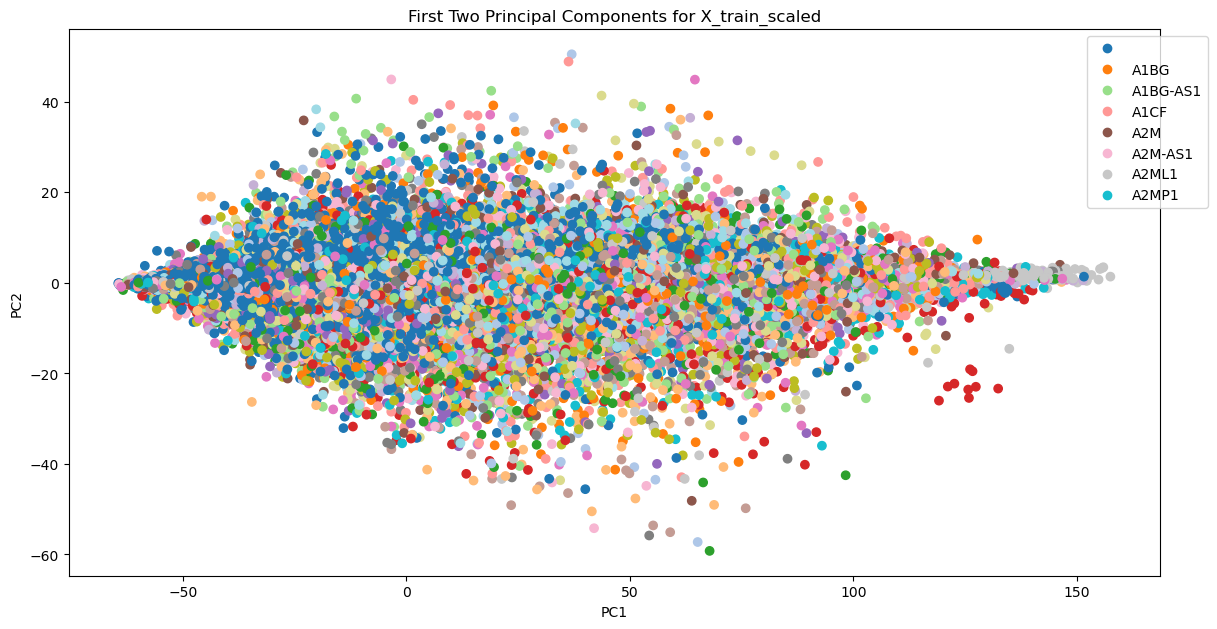

In [ ]:
#PCA, by gene
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(12,6))
genes_set, genes_colors = np.unique(y_train, return_inverse=True)
plot = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=genes_colors, cmap='tab20')
handles, _ = plot.legend_elements(prop="colors")

plt.legend(handles, genes_set, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First Two Principal Components for X_train_scaled")
plt.show()

In [22]:
unique_genes = y_train.unique()
print(unique_genes.shape)

(22881,)


In [ ]:
#t-SNE, By gene
tsne = TSNE(n_components=2, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_scaled)


plt.figure(figsize=(12,6))
tissues_set, tissues_colors = np.unique(y_train, return_inverse=True)
plot = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=tissues_colors, cmap='tab20')
handles, _ = plot.legend_elements(prop="colors")

plt.legend(handles, tissues_set, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE perplexity=5 for X_train_scaled")
plt.show()

KeyboardInterrupt: 

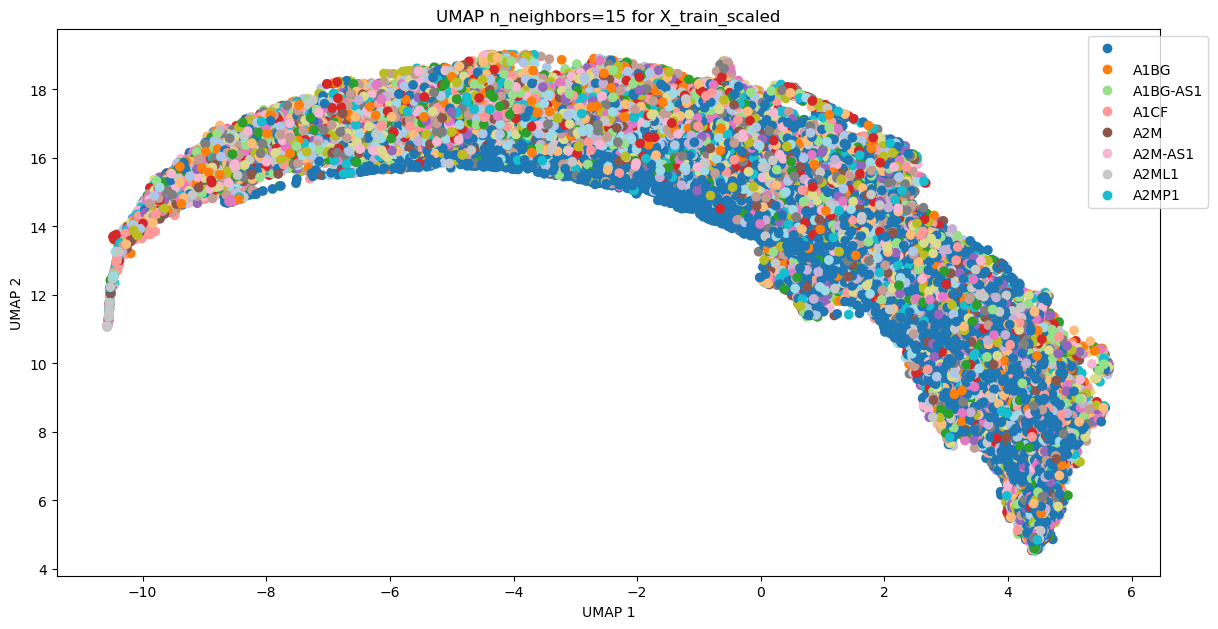

In [ ]:
#UMAP, by gene
reducer = umap.UMAP(n_neighbors=15)
X_train_umap = reducer.fit_transform(X_train_scaled)

plt.figure(figsize=(12,6))
tissues_set, tissues_colors = np.unique(y_train, return_inverse=True)
plot = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=tissues_colors, cmap='tab20')
handles, _ = plot.legend_elements(prop="colors")

plt.legend(handles, tissues_set, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP n_neighbors=15 for X_train_scaled")
plt.show()

In [62]:
#get and clean data for pca with types
X_train_T = X_train_scaled.T #rows = samples, columns = genes
X_train_T_scaled = scaler.fit_transform(X_train_T)
print(X_train_T_scaled.shape)

print(df_chars.shape)


(2096, 54630)
(2096, 1)


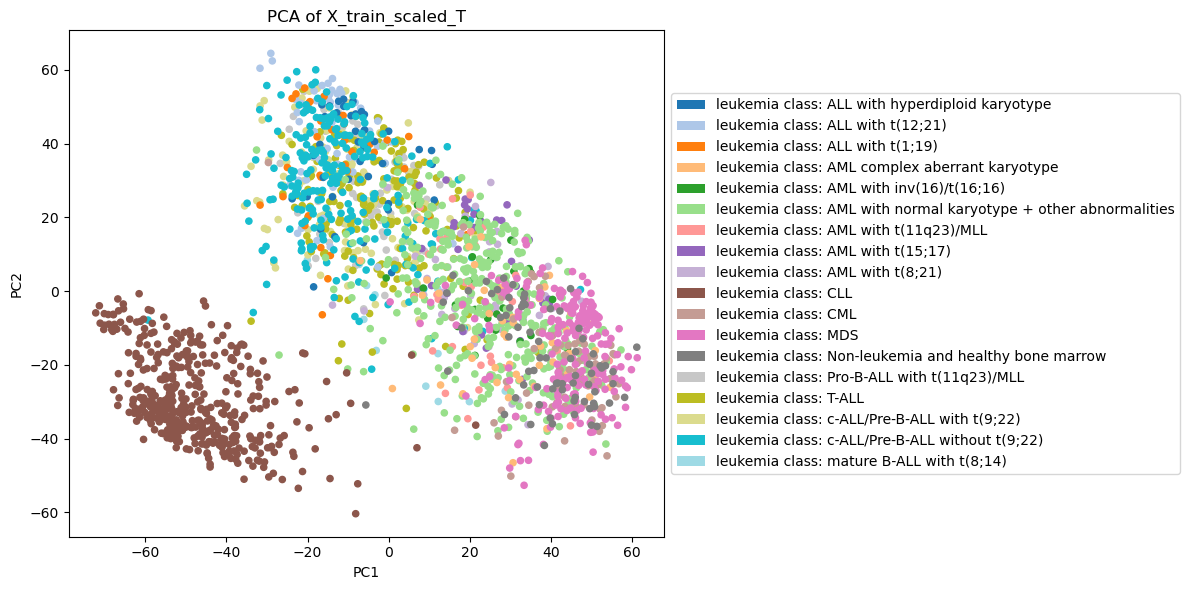

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# PCA, by types of leukemia
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled_T)

# Convert labels to integers
types_set, type_ids = np.unique(df_chars_train, return_inverse=True)

plt.figure(figsize=(12, 6))

scatter = plt.scatter(
    X_train_pca[:,0],
    X_train_pca[:,1],
    c=type_ids,
    cmap='tab20',
    s=20
)

legend_elements = [
    Patch(facecolor=scatter.cmap(scatter.norm(i)), label=types_set[i])
    for i in range(len(types_set))
]

# Place legend to the right outside the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of X_train_scaled_T")
plt.tight_layout()
plt.show()



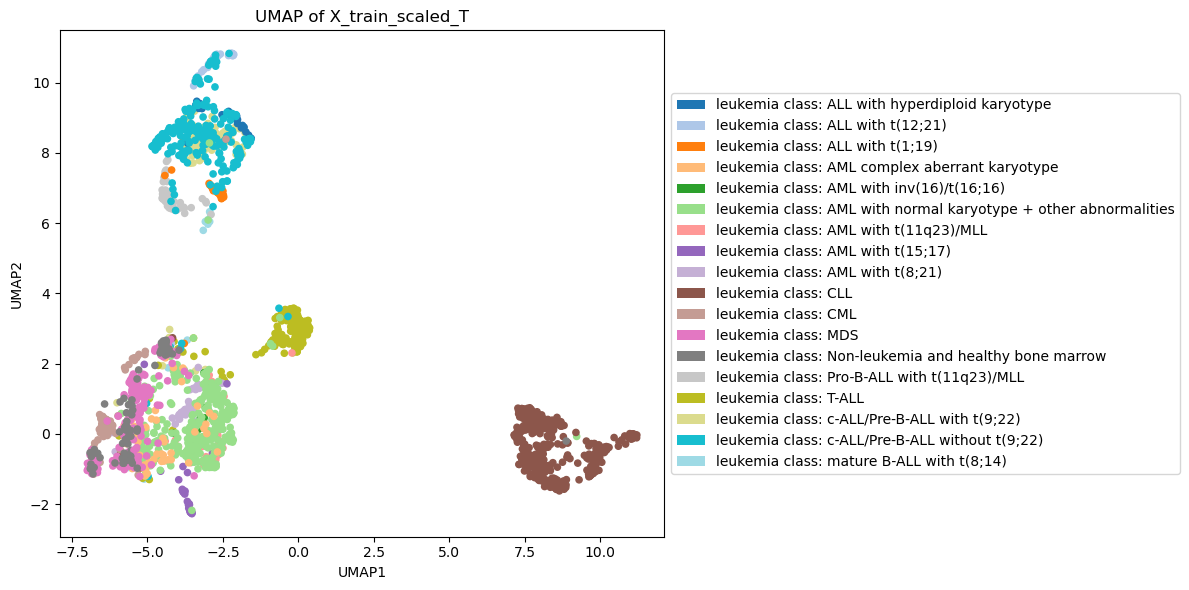

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

#UMAP, by types of leukemia

reducer = umap.UMAP(n_neighbors=10)
X_train_umap = reducer.fit_transform(X_train_scaled_T)

# Convert labels to integers
types_set, type_ids = np.unique(df_chars_train, return_inverse=True)

plt.figure(figsize=(12, 6))

scatter = plt.scatter(
    X_train_umap[:,0],
    X_train_umap[:,1],
    c=type_ids,
    cmap='tab20',
    s=20
)

legend_elements = [
    Patch(facecolor=scatter.cmap(scatter.norm(i)), label=types_set[i])
    for i in range(len(types_set))
]

# Place legend to the right outside the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of X_train_scaled_T")
plt.tight_layout()
plt.show()



In [71]:
num_labels = np.unique(df_chars_train)
print(len(num_labels))

18
